In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import scipy
%matplotlib inline

### Функция калибровки весов

Функция принимает на вход вспомогательные признаки $X_i$, $i \in S$, где $S$ -- множество индексов элементов, попавших в выборку, соответствующие признакам значения сумм $T$ по всей генеральной совокупности и набор начальных весов $\{d_i : i \in S\}$. Функция решает задачу оптимизации (4.7)
$$
    \begin{cases}
        \sum\limits_{i \in S} d_i G_\lambda \left( \frac{w_i}{d_i} \right) \rightarrow \min\limits_{\{w_i : i \in S\}},\\
        \sum\limits_{i \in S} w_i X_i = T.
    \end{cases}
$$
и возвращает калиброванные веса $w_i$, $i \in S$. Функция $G_\lambda$ определена в формуле (4.8):
$$
    G_\lambda =
    \begin{cases}
        x\log x - x + 1, \quad \text{если $\lambda = 0$},\\
        \frac{x^{\lambda + 1} - (\lambda + 1)(x - 1) - 1}{\lambda(\lambda + 1)}, \quad \text{если $\lambda > 0$,}
    \end{cases}
$$
где параметр $\lambda \in [0, 1]$ подается на вход функции. Функция описана в Главе 4.2 отчета.

In [2]:
# Метод калибровки весов
#
# initial_weights -- массив формы (n_samples, ); массив начальных весов;
# обычно равен 1 / вероятности_появления
#
# features -- массив формы (n_features x n_samples); массив признаков
#
# totals -- массив формы (n_features, ); суммы признаков по всей генеральной совокупности
#
# power -- неотрицательное число; определяет меру расхождения G_power(x), которую предстоит минимизировать;
# G_power(x) = (x**(power + 1) - (power + 1) * (x - 1) - 1) / power / (power + 1);
# в случаяе power = 0 выражение для G_power(x) стоит понимать как поточечный предел
#
# Значение power = 1 соответствует процедуре GREG, power = 0 -- процедуре raking
#
# tol -- положительное число; значение power приравнивается к 0, если оно по абсолютной величине меньше tol 
#
# Параметры солвера (используется trust-constr):
#   gtol -- положительное число; солвер завершает работу, когда
#   максимальное абсолютное значение компонент градиента Лагранжиана и
#   нарушение ограничений меньше gtol
#
#   xtol -- положительное число; солвер завершает работу, когда радиус шара,
#   на котором функция аппроксимируется модельной, (trust radius) становится меньше xtol
#
#   maxiter -- натуральное число; максимальное число итераций
#
#   verbose -- число из множества {0, 1, 2, 3}, отображает уровень детализации информации о работе солвера
#   verbose = 0 -- информация не выводится
#   verbose = 1 -- выводится отчет о завершении задачи
#   verbose = 2 -- отображается прогресс после каждой итерации
#   verbose = 3 -- наиболее подробный отчет
#
# Возвращаемое значение -- одномерный массив весов, соответствующих элементам выборки
#
def calibrate_weights(initial_weights, features, totals, power=1, tol=1e-3,\
                      gtol=1e-8, xtol=1e-8, maxiter=1000, verbose=0):
    
    # Если power не из отрезка [0, 1], выдать ошибку
    if power < -tol or power > 1 + tol:
        raise ValueError()
    
    # Начальные веса
    d = initial_weights[:]
    # Векторы признаков
    X = features[:, :]
    # Объем выборки
    n = d.shape[0]
    
    D = np.diag(d)
    # Начальное приближение для численного решения задачи оптимизации
    # (является оценкой метода GREG)
    w0 = d + D @ X @ np.linalg.pinv(X.T @ D @ X) @ (totals - X.T @ d)
    
    # Ограничения на взвешенную сумму признаков X.T @ w == totals
    constraint = LinearConstraint(X.T, totals, totals)
    
    # Если power близка к 0, оптимизировать G_0 вместо G_power
    if np.abs(power) < tol:
        # Целевая функция, значение которой предстоить минимизировать
        obj = lambda x : x.T @ np.log(x / d) - np.sum(x)
        # Градиент функции, которую предстоит минимизировать
        grad = lambda x : np.log(x / d)
        # Численное решение задачи оптимизации с помощью scipy
        res = minimize(obj, x0=w0, constraints=constraint, method='trust-constr', jac=grad,\
                       options={'gtol' : gtol, 'xtol' : xtol, 'maxiter' : maxiter, 'verbose' : verbose})
        # Выдать предупреждение, если метод оптимизации не сошелся
        if res.success != 1:
            print('Warning: the optimization method did not converge')
        # Оптимальный набор весов
        w = res.x
    else:
        # Целевая функция, значение которой предстоить минимизировать
        obj = lambda x : d.T @ ((x / d)**(power + 1)) - (power + 1) * np.sum(x)
        # Градиент функции, которую предстоит минимизировать
        grad = lambda x : (power + 1) * ((x / d)**power - 1)
        # Численное решение задачи оптимизации с помощью scipy
        res = minimize(obj, x0=w0, constraints=constraint, method='trust-constr', jac=grad,\
                       options={'gtol' : gtol, 'xtol' : xtol, 'maxiter' : maxiter, 'verbose' : verbose})
        # Выдать предупреждение, если метод оптимизации не сошелся
        if res.success != 1:
            print('Warning: the optimization method did not converge')
        # Оптимальный набор весов
        w = res.x
    
    return w

### Численные эксперименты

### Пример: искусственные данные, калибровка по двум числовым признакам

In [3]:
## тестирование банка синтетика
data = pd.read_csv("bank_data_generation.csv", sep = ';')
data.head()

,INN,CUSTOMER_TYPE,ACC_BALANCE_RUR,REGISTRATION_DT,CRM_CA_TB_NM,TOTAL_CNT,GROUP
0,0,ИП,4599501.73,4361,Северо-Западный банк,20,1
1,1,Юр. лицо,497001.05,3499,Центральный аппарат,0,0
2,2,ИП,4665023.98,2368,Центрально-Черноземный банк,17,0
3,3,ИП,2269175.70,2666,Среднерусский банк,4,0
4,4,ИП,5279232.45,4389,Поволжский банк,0,0


In [4]:
# Выбор признаков для калибровки
feature_columns = ['ACC_BALANCE_RUR', 'CUSTOMER_TYPE']

# Целевая переменная
target_column = 'TOTAL_CNT'

# оставим нужные фичи

data = data[['INN','CUSTOMER_TYPE',
'ACC_BALANCE_RUR',
'TOTAL_CNT']]

# Каждое уникальное значение категории в бинарных признаках заменим на число
for i in range (len(data.dtypes)):
   
    if(data.dtypes[i] == 'object'):
        if(data[data.dtypes.index[i]].nunique() == 2):
            print(data.dtypes.index[i], data.dtypes[i])
            #print(data[data.dtypes.index[i]].nunique())            
            print(data[data.dtypes.index[i]].unique()[0], data[data.dtypes.index[i]].unique()[1])
            data.loc[data[data.dtypes.index[i]] == data[data.dtypes.index[i]].unique()[0], data.dtypes.index[i]] = 0
            data.loc[data[data.dtypes.index[i]] == data[data.dtypes.index[i]].unique()[1], data.dtypes.index[i]] = 1

# Приводит столбец CUSTOMER_TYPE к типу float64
data = data.astype({'INN': 'int64','CUSTOMER_TYPE' : 'float64',\
                    'ACC_BALANCE_RUR' : 'float64', 'TOTAL_CNT' : 'int64'})

data.head()            

CUSTOMER_TYPE object
ИП Юр. лицо


,INN,CUSTOMER_TYPE,ACC_BALANCE_RUR,TOTAL_CNT
0,0,0.0,4599501.73,20
1,1,1.0,497001.05,0
2,2,0.0,4665023.98,17
3,3,0.0,2269175.70,4
4,4,0.0,5279232.45,0


In [5]:
# Подсчет суммарных значений для каждого признака по генеральной совокупности
totals = np.sum(np.array(data[feature_columns]), axis=0)
print(totals)

[2.92527125e+09 5.09000000e+02]


In [6]:
# Объем генеральной совокупности
n_total = data.shape[0]

# Объем выборки (не более n_total)
n_sample = 150

# Начальные веса
initial_weights = n_total / n_sample * np.ones(n_sample)

In [7]:
np.random.seed(13)

# Генерирование выборки - выбирает из датасета
sample = np.random.choice(data['INN'], size=n_sample, replace=False) #ID
# Вывод ID клиентов, попавших в выборку 
print(sample)

[945 452 304 433 864 291 986 923 260 546 591 390 407 261 594 618 196  78
 765 644 991 417 416 165 279 388 576 810 729 669 785 674 987 480 612 362
 855  70 779 675 545 337 736 740 687 380 414 346 570 189 751 593 743 663
 108 878 542 192 371 561 972 336 670 872 553 624 647 577 472 114  63  15
 275 423 458 822 928 830 828 512 222 195 459 799 363 980 705  98 733  46
 731 411 721  58 877 430 677  99 918 921 320 946 725 248 974 277  85 298
  21 931 808 200 849 676 293  77 372  51 722 667 216 366 299  52 807 266
 185 794 367 445 746 693 993 564  87 464  65 400 566  10 206 273 484 539
 726 885 944 879 329 215]


In [8]:
# Составление массива признаков и массива целевой переменной
# соединяем ИНН с соответсвующими строками фичей


features = np.empty((0, len(feature_columns)))
y = []

for s in sample:
    
    s_features = data[data['INN'] == s][feature_columns]
    features = np.append(features, np.array(s_features).reshape(1, -1), axis=0)
    
    y += [data[data['INN'] == s][target_column]]

y = np.array(y).reshape(-1)

In [9]:
y

array([ 5,  5,  0, 10,  8, 17, 24, 21, 18, 21,  9,  9, 19,  2,  6, 15, 24,
       16, 16,  4, 21, 22, 24, 16, 12,  6, 20,  7, 21, 11, 16, 12,  1, 18,
        9, 20, 15, 24, 21, 14, 11, 21, 15, 16, 15,  4, 15,  6,  1,  9, 14,
       11,  5,  5,  2, 24, 19, 20, 24, 12,  2,  6,  6, 10,  4, 13, 17, 21,
        1, 23,  8,  2, 24, 14, 11, 16, 10,  3,  7,  7, 14, 13, 13,  0, 19,
       18,  5,  4,  0,  4, 15, 14, 25, 18,  6, 25, 17,  1, 24,  7,  7, 11,
       23, 22, 20,  1,  6, 18, 21, 21,  1,  5, 19, 20,  4,  2, 15,  6,  6,
       17, 16, 24, 16,  8,  5, 16, 16,  1, 12,  7,  0,  3,  1, 17,  3, 14,
        6, 18,  6, 11, 16, 24, 13, 21,  2, 23,  8, 21, 21, 15])

In [10]:
features

array([[4.41208453e+06, 0.00000000e+00],
       [1.08893129e+06, 0.00000000e+00],
       [1.91595397e+06, 1.00000000e+00],
       [3.59433296e+06, 1.00000000e+00],
       [4.21512887e+06, 1.00000000e+00],
       [4.81344180e+05, 0.00000000e+00],
       [7.72866260e+05, 0.00000000e+00],
       [5.03935833e+06, 0.00000000e+00],
       [3.33109855e+06, 1.00000000e+00],
       [5.33534672e+06, 1.00000000e+00],
       [4.70239880e+05, 0.00000000e+00],
       [8.74855250e+05, 0.00000000e+00],
       [2.08292053e+06, 1.00000000e+00],
       [1.33110397e+06, 1.00000000e+00],
       [1.66365040e+06, 1.00000000e+00],
       [7.74034820e+05, 1.00000000e+00],
       [4.53622556e+06, 0.00000000e+00],
       [1.46096898e+06, 0.00000000e+00],
       [9.48281280e+05, 1.00000000e+00],
       [5.39655914e+06, 0.00000000e+00],
       [1.29686786e+06, 1.00000000e+00],
       [2.58449705e+06, 0.00000000e+00],
       [2.57546520e+06, 1.00000000e+00],
       [4.22921580e+05, 1.00000000e+00],
       [2.832050

In [11]:
# Сравнение процедур калибровки при различных значениях степени

power_list = np.linspace(0, 1, 21)

estimates = []

for p in power_list:
    w = calibrate_weights(initial_weights, features, totals, power=p)
    estimates += [w.T @ y]

Наилучшее значение показателя: 1.0


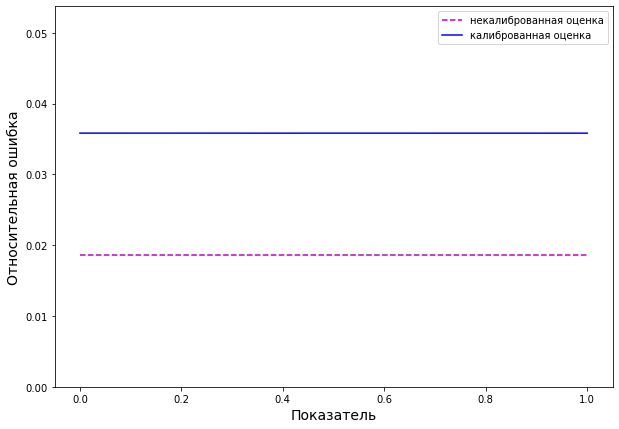

In [12]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()

# Стандартная (некалиброванная) оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample

# Подсчет величины ошибки и поиск оптимального значения степени

# Относительная ошибка стандартной оценки
error_naive = np.abs(y_naive - y_total) / y_total

# Относительные ошибки калиброванных оценок
errors = np.abs(estimates - y_total) / y_total

power_best = power_list[np.argmin(errors)]
print('Наилучшее значение показателя:', power_best)

plt.figure(figsize=(10, 7))
plt.plot(power_list, error_naive * np.ones(len(power_list)), 'm--', label='некалиброванная оценка')
plt.plot(power_list, errors, 'b-', label='калиброванная оценка')
plt.xlabel('Показатель', fontsize=14)
plt.ylabel('Относительная ошибка', fontsize=14)
plt.ylim(0, np.maximum(np.max(errors), error_naive) * 1.5)
plt.legend(loc=0)
#plt.savefig('images/calibration_loan_data.png')
plt.show()

In [13]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()
print('Сумма генеральной совокупности:', y_total)

print()

# Стандартная оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample
print('Стандартная (некалиброванная) оценка:', y_naive)

print()
print('Калибровка методом GREG')

# Калибровка методом GREG
w = calibrate_weights(initial_weights, features, totals, power=1, verbose=1)
print('Оценка GREG:', w.T @ y)

print()
print('Калибровка методом Raking ratio')

# Калибровка методом raking ratio
w = calibrate_weights(initial_weights, features, totals, power=0, verbose=1)
print('Оценка Raking ratio:', w.T @ y)

print()
print('Калибровка с наилучшим показателем степени')

# Калибровка с наилучшим показателем
w = calibrate_weights(initial_weights, features, totals, power=power_best, verbose=1)
print('Калиброванная оценка с наилучшим показателем', power_best, ':', w.T @ y)

Сумма генеральной совокупности: 12662

Стандартная (некалиброванная) оценка: 12426.666666666668

Калибровка методом GREG
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 2.64e-16, constraint violation: 4.55e-13, execution time: 0.0008 s.
Оценка GREG: 12208.517169319248

Калибровка методом Raking ratio
`gtol` termination condition is satisfied.
Number of iterations: 5, function evaluations: 7, CG iterations: 4, optimality: 8.54e-10, constraint violation: 1.71e-13, execution time: 0.0055 s.
Оценка Raking ratio: 12208.438281025272

Калибровка с наилучшим показателем степени
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 2.64e-16, constraint violation: 4.55e-13, execution time: 0.00033 s.
Калиброванная оценка с наилучшим показателем 1.0 : 12208.517169319248
